In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('dynamic_pricing.csv')
print(data.head())

   Number_of_Riders  Number_of_Drivers Location_Category  \
0                90                 45             Urban   
1                58                 39          Suburban   
2                42                 31             Rural   
3                89                 28             Rural   
4                78                 22             Rural   

  Customer_Loyalty_Status  Number_of_Past_Rides  Average_Ratings  \
0                  Silver                    13             4.47   
1                  Silver                    72             4.06   
2                  Silver                     0             3.99   
3                 Regular                    67             4.31   
4                 Regular                    74             3.77   

  Time_of_Booking Vehicle_Type  Expected_Ride_Duration  \
0           Night      Premium                      90   
1         Evening      Economy                      43   
2       Afternoon      Premium                      76  

In [2]:
# exploratory data analysis
print(data.describe())

       Number_of_Riders  Number_of_Drivers  Number_of_Past_Rides  \
count       1000.000000        1000.000000           1000.000000   
mean          60.372000          27.076000             50.031000   
std           23.701506          19.068346             29.313774   
min           20.000000           5.000000              0.000000   
25%           40.000000          11.000000             25.000000   
50%           60.000000          22.000000             51.000000   
75%           81.000000          38.000000             75.000000   
max          100.000000          89.000000            100.000000   

       Average_Ratings  Expected_Ride_Duration  Historical_Cost_of_Ride  
count      1000.000000              1000.00000              1000.000000  
mean          4.257220                99.58800               372.502623  
std           0.435781                49.16545               187.158756  
min           3.500000                10.00000                25.993449  
25%           3.8

In [3]:
# plotting ride duration vs cost of ride
fig = px.scatter(data, x='Expected_Ride_Duration',
                 y='Historical_Cost_of_Ride',
                 title='Expected Ride Duration vs Historical Cost of Ride',
                 trendline='ols')
fig.show()

In [4]:
# plotting a box plot for cost of ride vs vehicle type
fig = px.box(data, x='Vehicle_Type',
             y='Historical_Cost_of_Ride',
             title='Historical Cost of Ride Distribution vs Vehicle Type')
fig.show()

In [5]:
# plotting a box plot for cost of ride vs time of booking
fig = px.box(data, x='Time_of_Booking',
             y='Historical_Cost_of_Ride',
             title='Historical Cost of Ride Distribution vs Time of Booking')
fig.show()

In [6]:
data.corr()

<ipython-input-6-c44ded798807>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
Number_of_Riders,1.000000,0.627016,0.029265,0.008572,-0.015856,0.005826
Number_of_Drivers,0.627016,1.000000,0.039660,0.041204,-0.024418,0.017082
Number_of_Past_Rides,0.029265,0.039660,1.000000,-0.064734,0.030679,0.035859
Average_Ratings,0.008572,0.041204,-0.064734,1.000000,-0.016968,-0.001063
Expected_Ride_Duration,-0.015856,-0.024418,0.030679,-0.016968,1.000000,0.927547
Historical_Cost_of_Ride,0.005826,0.017082,0.035859,-0.001063,0.927547,1.000000


<ipython-input-7-8b96879b4d02>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

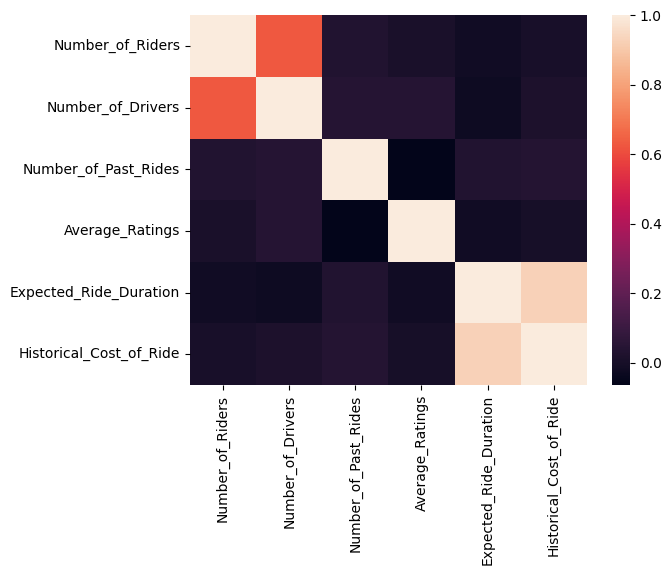

In [7]:
sns.heatmap(data.corr())

In [8]:
# implementing the dynamic pricing strategy
import numpy as np

# calculating demand_multiplier based on percentile for high and low demand
high_demand_percentile = 75
low_demand_percentile = 25


data['demand_multiplier'] = np.where(data['Number_of_Riders'] > np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], low_demand_percentile)
                                     )

# calculating supply_multiplier based on percentile for high and low supply
high_supply_percentile = 75
low_supply_percentile = 25

data['supply_multiplier'] = np.where(data['Number_of_Drivers'] > np.percentile(data['Number_of_Drivers'], low_supply_percentile),
                                     np.percentile(data['Number_of_Drivers'], high_supply_percentile) / data['Number_of_Drivers'],
                                     np.percentile(data['Number_of_Drivers'], low_supply_percentile) / data['Number_of_Drivers']
                                     )

# defining the price adjustment factors for high and low demand supply
demand_threshold_high = 1.2 # higher demand threshold
demand_threshold_low = 0.8 # lower demand threshold
supply_threshold_high = 0.8 # higher supply threshold
supply_threshold_low = 1.2 # lower supply threshold

# calculating adjusted_ride_cost for dynamic pricing
data['adjusted_ride_cost'] = data['Historical_Cost_of_Ride'] * (
    np.maximum(data['demand_multiplier'], demand_threshold_low) *
    np.maximum(data['supply_multiplier'], supply_threshold_high)
)

In [9]:
#calculating profit percentage for each ride using dynamic pricing strategy
data['profit_percentage'] = ((data['adjusted_ride_cost'] - data['Historical_Cost_of_Ride']) / data['Historical_Cost_of_Ride']) * 100

#ID profitable rides when profit percentage percentage is positive
profitable_rides = data[data['profit_percentage'] > 0]

#ID rides incurring losses when profit percentage is negative
loss_rides = data[data['profit_percentage'] < 0]

import plotly.graph_objects as go

#calculate the count of profitable and loss rides
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

#creating a donut chart to show the distribution of profitable and loss rides using the dynamic pricing strategy
labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.4)])
fig.update_layout(title='Profitability of Rides (Dynamic Pricing vs Historical Pricing)')
fig.show()

In [10]:
# created a scatter plot graph to view relationship between expected ride duration
# and the cost of the ride based on dynamic pricing strategy
fig = px.scatter(data,
                 x = 'Expected_Ride_Duration',
                 y = 'adjusted_ride_cost',
                 title = 'Expected Ride Duration vs Cost of Ride',
                 trendline='ols')

fig.show()

In [11]:
# training a predictive ML model
from sklearn.preprocessing import StandardScaler

def data_preprocessing_pipeline(data):
  # ID numeric and categorical features
  numeric_features = data.select_dtypes(include=['float', 'int']).columns
  categorical_features = data.select_dtypes(include=['object']).columns

  # handling missing values in numeric features
  data[numeric_features] = data[numeric_features].fillna(data[numeric_features].mean())

  # detecting and handling outliers in numeric features using IQR
  for feature in numeric_features:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 = Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    data[feature] = np.where((data[feature] < lower_bound) | (data[feature] > upper_bound),
                             data[feature].mean(), data[feature])

    # handling missing values in categorical features
    data[categorical_features] = data[categorical_features].fillna(data[categorical_features].mode().iloc[0])

    return data

In [12]:
# converting vehicle type to a numerical feature
data['Vehicle_Type'] = data['Vehicle_Type'].map({'Premium': 1, 'Economy': 0})

In [13]:
# converting time of booking to a numerical feature
data['Time_of_Booking'] = data['Time_of_Booking'].map({'Afternoon': 0, 'Evening': 1, 'Morning': 2, 'Night': 3})

In [14]:
# splitting data into train and test
from sklearn.model_selection import train_test_split

x = np.array(data[['Number_of_Riders', 'Number_of_Drivers', 'Vehicle_Type', 'Time_of_Booking', 'Expected_Ride_Duration']])
y = np.array(data[['adjusted_ride_cost']])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# reshape y to 1D array
y_train = y_train.ravel()
y_test = y_test.ravel()

# training a random forest regression model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

In [15]:
# testing the ML model using some input values
def get_vehicle_type_numeric(vehicle_type):
  vehicle_type_mapping = {
      "Premium": 1,
      "Economy": 0
  }
  vehicle_type_numeric = vehicle_type_mapping.get(vehicle_type)
  return vehicle_type_numeric

def get_time_of_booking_numeric(time_of_booking):
  time_of_booking_mapping = {
      "Afternoon": 0,
      "Evening": 1,
      "Morning": 2,
      "Night": 3
  }
  time_of_booking_numeric = time_of_booking_mapping.get(time_of_booking)
  return time_of_booking_numeric

# making prediction using user input values
def predict_price(number_of_riders, number_of_drivers, vehicle_type, time_of_booking, Expected_Ride_Duration):
  vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
  if vehicle_type_numeric is None:
    raise ValueError("Invalid vehicle type")

  time_of_booking_numeric = get_time_of_booking_numeric(time_of_booking)
  if time_of_booking_numeric is None:
    raise ValueError("Invalid time of booking")

  input_data = np.array([[number_of_riders, number_of_drivers, vehicle_type_numeric, time_of_booking_numeric, Expected_Ride_Duration]])
  predicted_price = model.predict(input_data)
  return predicted_price

# user input example
user_number_of_riders = 65
user_number_of_drivers = 30
user_vehicle_type = "Economy"
user_time_of_booking = "Afternoon"
Expected_Ride_Duration = 50
predicted_price = predict_price(user_number_of_riders, user_number_of_drivers, user_vehicle_type, user_time_of_booking, Expected_Ride_Duration)
print("The predicted price for the ride is: ", predicted_price)

The predicted price for the ride is:  [426.53895898]


In [16]:
# model prediction
y_pred = model.predict(x_test)

# checking model accuracy
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)*100

86.0075164974731

In [18]:
# comparison of actual and predicted results
import plotly.graph_objects as go

# predict on the test set
y_pred = model.predict(x_test)

# create a scatter plot with actual vs predicted values
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_test.flatten(),
    y=y_pred,
    mode='markers',
    name='Actual vs Predicted'
))

# add a line representing the ideal case
fig.add_trace(go.Scatter(
    x=[min(y_test.flatten()), max(y_test.flatten())],
    y=[min(y_test.flatten()), max(y_test.flatten())],
    mode='lines',
    name='Ideal',
    line=dict(color='red', dash='dash')

))

fig.update_layout(
    title='Actual vs Predicted Values',
    xaxis_title='Actual Values',
    yaxis_title='Predicted Values',
    showlegend=True
)

fig.show()